The dataset used for this notebook is from https://www.kaggle.com/c/tabular-playground-series-jan-2021

"Linear regression excels at extrapolating trends, but can't learn interactions. XGBoost excels at learning interactions, but can't extrapolate trends." - Hybrid model method take from kaggle course: https://www.kaggle.com/ryanholbrook/hybrid-models

In this notebook, I am using Linear Regression to fit the original target series, then using the second algorithm (XGBoost) to fit the residual series. This process is using LR to extrapolate the trend, transform the target to remove the trent, then apply XGBoost to the detrended residuals. 

Results of the hybrid model are in the last cell of this notebook

## Sections

1. [Load in libraries, set defaults, load in data](#Section-1:-Load-in-libraries,-set-defaults,-load-in-data)
2. [Feature Engineering](#Section-2:-Feature-Engineering)
3. [Building the Hybrid Model](#Section-3:-Building-the-hybrid-model)
4. [Visualization of results, SMAPE](#Section-4:-Visualization-of-Results,-SMAPE)

# Section 1: Load in libraries, set defaults, load in data


In [1]:
# load in libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from warnings import simplefilter
simplefilter("ignore")
import holidays
import datetime
import numpy as np
from sklearn.preprocessing import LabelEncoder


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(15, 45),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)


#### Data is split into a training set (2015-2017) and validation set (2018). The test set is 2019.

In [2]:
df = pd.read_csv('train.csv',
    parse_dates=['date'])
df_test = pd.read_csv('test.csv',
    parse_dates=['date'])
y = df.pivot(index='date', columns=['product', 'store', 'country'], values='num_sold')

idx_train, idx_test = train_test_split(
    y.index, test_size=365, shuffle=False,
)
X_train, X_test = df[df.date.isin(idx_train)], df[df.date.isin(idx_test)]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Section 2: Feature Engineering

In [3]:
# preparing dataset for the linear model

fourier = CalendarFourier(freq="A", order=10)

dp = DeterministicProcess(
    index=y_train.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # quadratic trend
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_1_train = dp.in_sample()  # features for the training data
X_1_test = dp.out_of_sample(365, forecast_index=y_test.index) # features for the training data

In [14]:
gdp_df

,year,country,GDP
0,2015,Finland,234.440
1,2015,Norway,385.802
2,2015,Sweden,505.104
3,2016,Finland,240.608
4,2016,Norway,368.827
5,2016,Sweden,515.655
6,2017,Finland,255.017
7,2017,Norway,398.394
8,2017,Sweden,541.019
9,2018,Finland,275.580


In [4]:
# preparing dataset for xgboost model

gdp_df = pd.read_csv('Best_GDP.csv', index_col=0)

holiday_FI = holidays.CountryHoliday('FI', years=[2015, 2016, 2017, 2018, 2019])
holiday_NO = holidays.CountryHoliday('NO', years=[2015, 2016, 2017, 2018, 2019])
holiday_SE = holidays.CountryHoliday('SE', years=[2015, 2016, 2017, 2018, 2019])

holiday_dict = holiday_FI.copy()
holiday_dict.update(holiday_NO)
holiday_dict.update(holiday_SE)


def fe(df):
    '''
    Feature Engineering (fe) for xgboost
    '''
    
    # dates feature engineering
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['dayofyear'] = df.date.dt.dayofyear
    df['dayofweek'] = df.date.dt.dayofweek
    df['is_weekend'] = df['dayofweek'].apply(lambda x : 1 if x in [5,6] else 0)
    df['is_friday'] = df['dayofweek'].apply(lambda x : 1 if x == 4 else 0)
    df['quarter'] = df.date.dt.quarter
    df['time_step'] = (df['date'] - datetime.datetime(2015, 1, 1)).dt.days
    

    #add in gdps of each country
    df = pd.merge(df, gdp_df, how='left', on=['year', 'country'])

    # holiday dates
    df['holiday_name'] = df['date'].map(holiday_dict)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df.drop('holiday_name', axis=1, inplace=True)
    
    #label encoding
    le = LabelEncoder()
    df['country'] = le.fit_transform(df['country'])
    df['store'] = le.fit_transform(df['store'])
    df['product'] = le.fit_transform(df['product'])
    
    df.drop('date', axis=1, inplace=True)
    
    return df

X_2_train = fe(X_train)
X_2_test = fe(X_test)

# Section 3: Building the hybrid model

### 1) Define Models

In [5]:
class HybridModel:
    def __init__(self, model_1, model_2, grid=None):
        self.model_1 = model_1
        self.model_2 = model_2
        self.grid=grid
        self.y_columns = None  # store column names from fit method
        

### 2) Define fit/train method (y_fit)

In [6]:
# Implementing GridSearch within Hybrid method idea from: https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model

def fit(self, X_train_1, X_train_2, y_train):
    # Train model 1
    self.model_1.fit(X_train_1, y_train)
        
    # Predictions from model 1 (trend)
    y_fit_1 = pd.DataFrame(
        self.model_1.predict(X_train_1), 
        index=X_1_train.index, columns=y_train.columns,
    )
    
    # compute residuals
    y_resid = y_train - y_fit_1
    y_resid = y_resid.stack().stack().stack().squeeze() # wide to long

    #perform GridSearch
    if self.grid:
        tscv = TimeSeriesSplit(n_splits=3)
        grid_model = GridSearchCV(estimator=self.model_2, cv=tscv, param_grid=self.grid)
        
        # Train model 2 on detrended series
        grid_model.fit(X_train_2, y_resid)
            
        # Model 2 preditions (for residual analysis)
        y_fit_2 = grid_model.predict(X_train_2)
            
        # Save model
        self.grid_model=grid_model
    else:
        # Train model 2 on residuals
        self.model_2.fit(X_train_2, y_resid)
            
        # Model 2 preditions (for residual analysis)
        y_fit_2 = self.model_2.predict(X_train_2) 
        
    y_fit_1 = y_fit_1.stack().stack().stack().squeeze()
    y_fit = y_fit_1 + y_fit_2
    
    # Save data
    self.y_columns = y.columns
    self.y_fit = y_fit
    
    return y_fit

        
# Add fit method to class
HybridModel.fit = fit

### 3) Define predict method (y_pred)

In [7]:
def predict(self, X_test_1, X_test_2):
    # Predict trend using model 1
    y_pred_1 = pd.DataFrame(
        self.model_1.predict(X_test_1),
        index=X_test_1.index, 
        columns=self.y_columns).stack().stack().stack().squeeze()  # wide to long

        
    if self.grid:
    # Grid model predictions
        y_pred_2 = self.grid_model.predict(X_test_2)
    else:
        # Model 2 predictions
        y_pred_2 = self.model_2.predict(X_test_2)
        
    # Add predictions together
    y_pred = y_pred_1 + y_pred_2
        
    # Save data
    self.y_pred = y_pred
        
 #       return y_pred
    return y_pred

# Add method to class
HybridModel.predict = predict

### 4) Run HybridModel on datasets (X_1_train, X_2_train, X_1_test, X_2_test, y_train)

In [8]:
# Construct hybrid model
model_1 = LinearRegression()
model_2 = XGBRegressor()
param_grid = {'n_estimators': [100, 125, 150, 175, 200],
        'max_depth': [6, 7],
        'learning_rate': [0.075, 0.1, 0.125]}

model = HybridModel(model_1, model_2, grid=param_grid)

# Train model
y_fit = model.fit(X_1_train, X_2_train, y_train)

# Save predictions
y_pred = model.predict(X_1_test, X_2_test)

In [9]:
print('Best parameters:',model.grid_model.best_params_,'\n')

Best parameters: {'learning_rate': 0.075, 'max_depth': 6, 'n_estimators': 100} 



# Section 4: Visualization of Results, SMAPE
   #### y_train, y_test, y_fit, y_pred

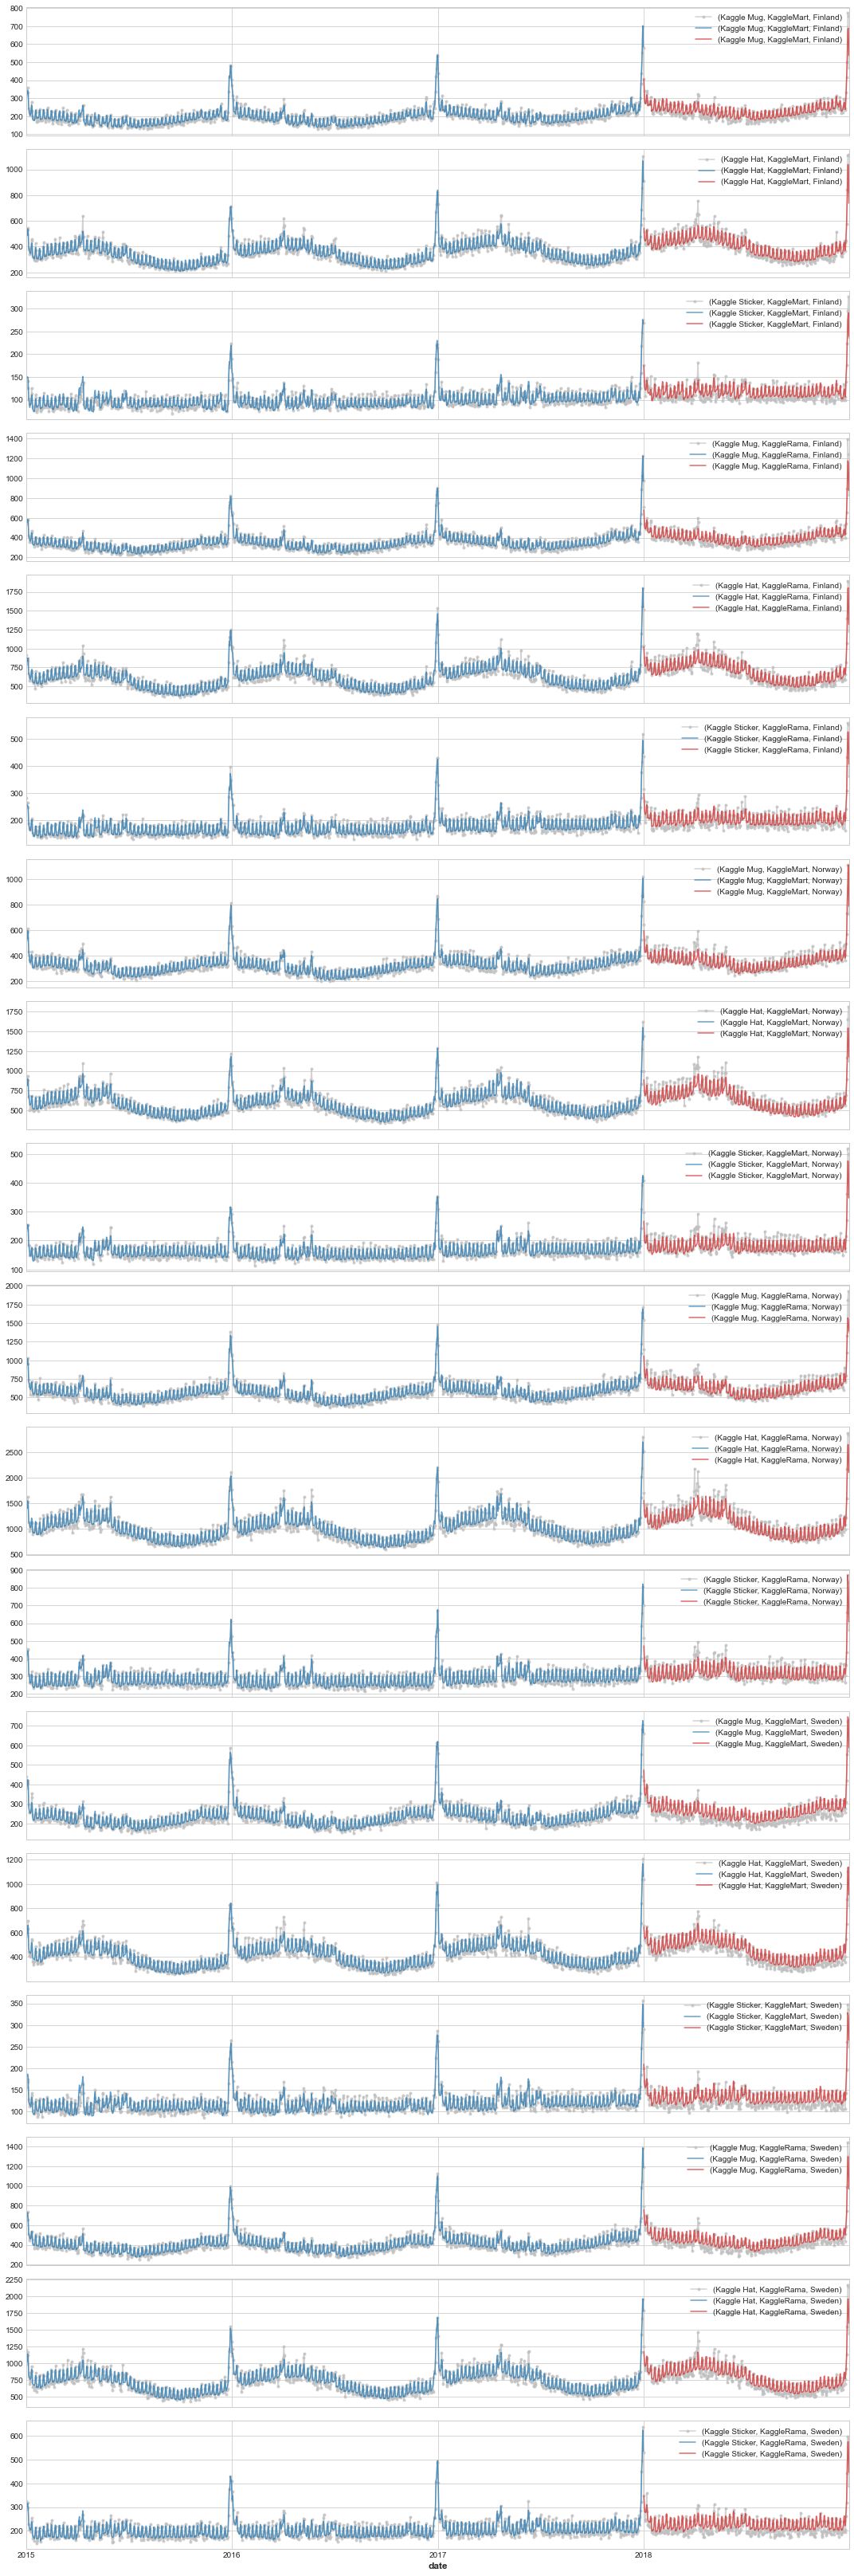

In [10]:
axs = y.plot(color='0.75', subplots=True, sharex=True, alpha=0.7,
    style=".-",
    markeredgecolor="0.75",
    markerfacecolor="0.75",)

_ = y_fit.unstack().unstack().unstack().reindex(y.columns, axis=1).plot(color='C0', subplots=True, sharex=True, alpha=0.7, label='y_fit',ax=axs)
_ = y_pred.unstack().unstack().unstack().reindex(y.columns, axis=1).plot(color='C3', subplots=True, sharex=True, alpha=0.7, label='y_fit',ax=axs)


y_fit and y_pred are not a perfect fit to y_train and y_test. There is still some randomness not accounted for.

## Loss function SMAPE

​​i=1​∑​N​​w​i​​​​100​i=1​∑​N​​​(∣t​i​​∣+∣a​i​​∣)/2​​w​i​​∣a​i​​−t​i​​∣​​​​

In [11]:
# https://www.kaggle.com/teckmengwong/tps2201-hybrid-time-series
def smape_loss(y_true, y_pred):
    """
    SMAPE Loss
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    Returns
    -------
    loss : float or ndarray of floats
        If multioutput is 'raw_values', then mean absolute error is returned
        for each output separately.
        If multioutput is 'uniform_average' or an ndarray of weights, then the
        weighted average of all output errors is returned.
        SMAPE output is non-negative floating point. The best value is 0.0.

    """
    assert(y_true.shape == y_pred.shape)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

### Model results on train dataset:

In [12]:
smape_loss(y_train, y_fit.unstack().unstack().unstack().reindex(y.columns, axis=1))

product         store       country
Kaggle Mug      KaggleMart  Finland    4.422016
Kaggle Hat      KaggleMart  Finland    4.367290
Kaggle Sticker  KaggleMart  Finland    5.174857
Kaggle Mug      KaggleRama  Finland    4.059963
Kaggle Hat      KaggleRama  Finland    4.428434
Kaggle Sticker  KaggleRama  Finland    4.100622
Kaggle Mug      KaggleMart  Norway     4.382539
Kaggle Hat      KaggleMart  Norway     4.566070
Kaggle Sticker  KaggleMart  Norway     4.124617
Kaggle Mug      KaggleRama  Norway     4.194482
Kaggle Hat      KaggleRama  Norway     4.611437
Kaggle Sticker  KaggleRama  Norway     3.783672
Kaggle Mug      KaggleMart  Sweden     4.426111
Kaggle Hat      KaggleMart  Sweden     4.651206
Kaggle Sticker  KaggleMart  Sweden     4.972559
Kaggle Mug      KaggleRama  Sweden     4.243910
Kaggle Hat      KaggleRama  Sweden     4.691359
Kaggle Sticker  KaggleRama  Sweden     4.015232
dtype: float64

### Model results on validation set:

In [13]:
smape_loss(y_test, y_pred.unstack().unstack().unstack().reindex(y.columns, axis=1))

product         store       country
Kaggle Mug      KaggleMart  Finland    6.559055
Kaggle Hat      KaggleMart  Finland    5.685001
Kaggle Sticker  KaggleMart  Finland    6.646959
Kaggle Mug      KaggleRama  Finland    6.106082
Kaggle Hat      KaggleRama  Finland    5.307632
Kaggle Sticker  KaggleRama  Finland    5.819322
Kaggle Mug      KaggleMart  Norway     5.815326
Kaggle Hat      KaggleMart  Norway     6.635848
Kaggle Sticker  KaggleMart  Norway     5.999263
Kaggle Mug      KaggleRama  Norway     5.397060
Kaggle Hat      KaggleRama  Norway     6.284484
Kaggle Sticker  KaggleRama  Norway     5.589828
Kaggle Mug      KaggleMart  Sweden     8.947370
Kaggle Hat      KaggleMart  Sweden     7.204736
Kaggle Sticker  KaggleMart  Sweden     8.006624
Kaggle Mug      KaggleRama  Sweden     7.281161
Kaggle Hat      KaggleRama  Sweden     6.484868
Kaggle Sticker  KaggleRama  Sweden     7.402843
dtype: float64